In [1]:
import sys
sys.executable

'/Applications/anaconda3/envs/slsl-new/bin/python'

In [2]:
import numpy as np
from collections import Counter
import pandas as pd
import sys
import os
import re
import json
import openslide
from matplotlib import pyplot as plt
import cv2
from shapely.geometry import asMultiPoint, Polygon, MultiPoint, asMultiPolygon, MultiPolygon
from shapely.geometry.collection import GeometryCollection

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [3]:
from slideslicer import RoiReader
import slideslicer as slsl

## Background

The histologic slides are often huge. Loading a whole slide into memory might be not the best idea. Here we use some tricks to sample tissue based on hand-labelled features as well as grid sampling in combination with color thresholding (to remove blank space)

## Overview
This tutorial focuses on basic operations (read slide & ROI, plot, inspect ROIs, geometric preprocessing operations on ROIs)

See [demo-feed-pytorch](demo-feed-pytorch.ipynb) for examples on how to feed a ready-to-use slide into a pytorch model and [demo-feed-keras](demo-feed-keras.ipynb) for use with Keras.


## ***<font color='red'>First thing first!</font>***
*Please start downloading the slide examples from this google drive folder:*

https://goo.gl/zwPAo3

## Glossary

slide

ROI (region of interest) -- a region in the image that can be represented by a contour or a mask.

countour

mask

## Read slides and annotations

`slideslicer.RoiReader` class provides an interface for reading, manipulation, and display for pathology slides and their annotations.

all `openslide`-readable slide types are supported. 

in this example we will work with SVS format and annotations from Aperio software in XML format

In [4]:
fnxml  = "../data/mouse-biosciencedbc-jp-vitamina-kidney/14112.xml"
fnsvs = re.sub(".xml$", ".svs", fnxml)
fnsvs

'../data/mouse-biosciencedbc-jp-vitamina-kidney/14112.svs'

In [5]:
rreader = RoiReader(fnxml, threshold_tissue=True,
                    verbose=True, # prints out counts of ROIs below 
                   )

---------------
counts of ROIs
---------------
glom      100
tissue      5
dtype: int64
---------------------------------------------
counts of ROIs after removing empty chunks
---------------------------------------------
glom      99
tissue     1
dtype: int64


# High-level / low-resolution display of slide and its contours

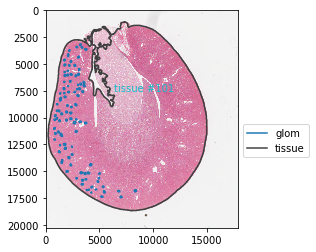

In [6]:
rreader.plot(labels=True)
plt.legend(loc='upper left', bbox_to_anchor=(1, 0.5))

## Inspect regions of interests (ROIs)

`RoiReader` object stores ROIs associated with a slide in a convenient `pandas.DataFrame` table.

the columns are derived from the annotation file, and not all of them are useful or meaningful. however,  following columns ARE useful:

- name  -- contains ROI name / type provided by the annotator (in this case all contours have name 'glom')
- vertices -- a list of vertices of the ROI contour
- polygon  -- a representation of ROI as `shapely.geometry.Polygon` object. this interface allows to easily perform manipulations with ROIs, such as intersections, unions, deriving convex hulls, and morphologic operations.
- area -- areas of the ROIs. one can use it for sanity check
- length -- contour length
- areamicrons -- area in ${\mu}m^2$
- lengthmicrons -- contour length in ${\mu}m$

In [7]:
rreader.df.head()

,analyze,area,areamicrons,displayid,id,imagefocus,imagelocation,inputregionid,length,lengthmicrons,name,negativeroa,selected,type,vertices,zoom,polygon
0,1.0,16592.0,4085.2,1.0,1,-1.0,,0.0,531.8,263.9,glom,1.0,0.0,0.0,"[(3161.0, 3197.0), (3161.0, 3200.0), (3161.0, ...",0.41,"POLYGON ((3161 3197, 3161 3200, 3161 3202, 316..."
1,1.0,15356.0,3780.9,2.0,2,-1.0,,0.0,516.0,256.0,glom,1.0,0.0,0.0,"[(2893.0, 3371.0), (2890.0, 3368.0), (2888.0, ...",0.41,"POLYGON ((2893 3371, 2890 3368, 2888 3368, 288..."
2,1.0,12731.5,3134.7,3.0,3,-1.0,,0.0,470.7,233.6,glom,1.0,0.0,0.0,"[(3320.0, 3419.0), (3317.0, 3419.0), (3315.0, ...",0.41,"POLYGON ((3320 3419, 3317 3419, 3315 3419, 331..."
3,1.0,19654.5,4839.2,4.0,4,-1.0,,0.0,646.4,320.8,glom,1.0,0.0,0.0,"[(3681.0, 3590.0), (3678.0, 3590.0), (3676.0, ...",0.41,"POLYGON ((3681 3590, 3678 3590, 3676 3592, 367..."
4,1.0,11433.0,2815.0,5.0,5,-1.0,,0.0,437.3,217.0,glom,1.0,0.0,0.0,"[(2194.0, 3697.0), (2193.0, 3698.0), (2191.0, ...",0.58,"POLYGON ((2194 3697, 2193 3698, 2191 3700, 219..."


## Visualize the shape of a tissue piece
`polygon` column stores ROIs as `shapely.geometry.Polygon` objects, which can be easily displayed in a notebook

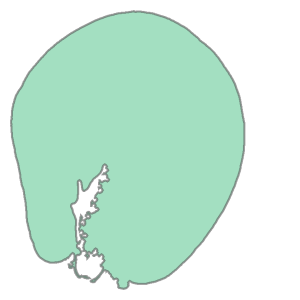

In [8]:
rreader.df_tissue.iloc[0]['polygon']
# we see that thresholding is not ideal, 
# but it's OK for our application
# you can tune it by passing thresholds to the RoiReader class constructor

## Perform descriptive analysis of annotated objects

### visualize distribution of glomeruli areas

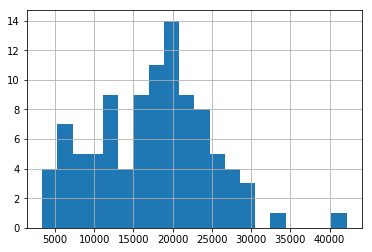

In [54]:
rreader.df[rreader.df.name!='tissue'].area.hist(bins=20)

### find median area of glomeruli ROIs

In [10]:
med_area = rreader.df[rreader.df.name!='tissue'].area.median()
med_area

17923.5

### what is the typical radius of a ROI?
$A = \pi R^2$

$R = \sqrt{A/ \pi}$

In [11]:
def get_radius(area):
    return np.sqrt(area/np.pi)

med_radius = get_radius(med_area)
med_radius

75.5329546953856

## Selecting a labelled region of the slide

in this case, I have labelled only a region of a mouse kidney for glomeruli (I made sure all gloms within the convex hull are labelled)

in order to make sure we are using only the labelled part of the slide (~ left half), we need to select a convex hull (envelope) of the glomeruli contours. we also want to avoid blank space that this envelope might contain -- therefore we'll intesect it with the tissue polygon.

for such geometric operations, we will be using `shapely` package, which `slideslicer` is build on.

to select the convex hull covering all glomeruli, we first collect contours named `"glom"` into a `MultiPolygon` object

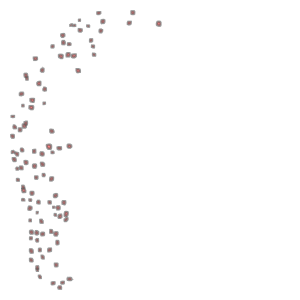

In [12]:
glomeruli = MultiPolygon(rreader.df.loc[rreader.df['name']!='tissue','polygon'].tolist())
glomeruli

note that this polygon collection display is turned upside down compared to the plot above, because the convention for image display is that `y=0` is at the top, while normally (like here with `shapely` display) `y=0` is at the bottom.

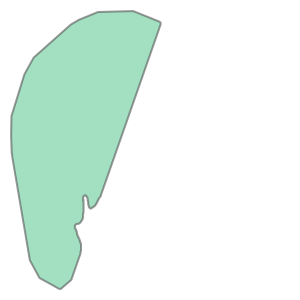

In [13]:
# select tissue
tissue = rreader.df.loc[rreader.df['name']=='tissue','polygon'].iloc[0]
# find intersection of the glomeruli's convex hull and the tissue
labelled_tissue = glomeruli.convex_hull.intersection(tissue)
labelled_tissue

additionally we might want to perform morphological opening on our convex hull before intersection for about a  diameter of a glom

In [14]:
labelled_tissue = glomeruli.convex_hull.buffer(2*med_radius).intersection(tissue)

# intersection might create several pieces, for simplicity we take the largest:
if isinstance(labelled_tissue, MultiPolygon):
    labelled_tissue = labelled_tissue[np.argmax([x.area for x in labelled_tissue])]

In [15]:
np.mean(rreader.df.areamicrons / rreader.df.area)

0.2462142805310981

### replace the 'tissue' ROI with the convex hull of labelled_tissue

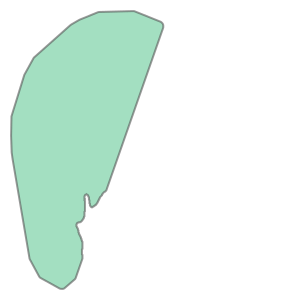

In [16]:
labelled_tissue

In [17]:
rreader.df.loc[rreader.df['name']=='tissue','polygon'] = labelled_tissue
rreader.df.loc[rreader.df['name']=='tissue','vertices'] = \
        rreader.df.loc[rreader.df['name']=='tissue','polygon'].map(lambda pg: np.asarray(pg.boundary).tolist())
rreader.df.loc[rreader.df['name']=='tissue','area'] = \
        rreader.df.loc[rreader.df['name']=='tissue','polygon'].map(lambda pg: pg.area)

## save ROIs as a JSON file

In [18]:
json_filename = rreader.save()
print(json_filename)

../data/mouse-biosciencedbc-jp-vitamina-kidney/14112.json


## Visualize the shape of the cropped tissue piece

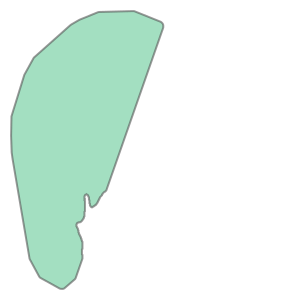

In [19]:
rreader.df_tissue.iloc[0]['polygon']

## Sample points within the piece

### Randomly

244


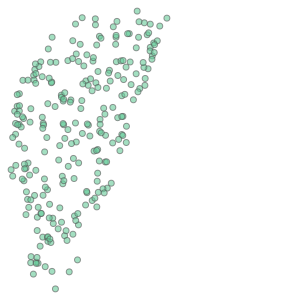

In [20]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], n_points=200,  mode='uniform_random', random_seed=42)
print(len(points))
asMultiPoint(points)

### On a grid

198


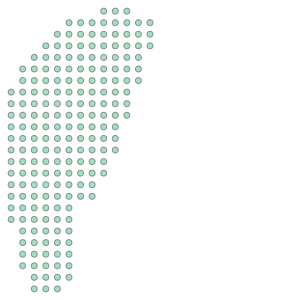

In [21]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], n_points=200, mode='grid')
print(len(points))
asMultiPoint(points)

198


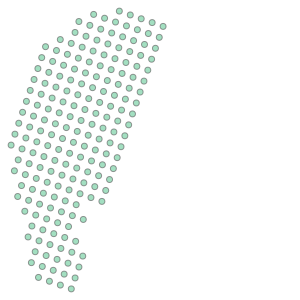

In [22]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], n_points=200,  mode='rotated_grid')
print(len(points))
asMultiPoint(points)

### execution time

In [23]:
%%timeit
points = slsl.sample_points(rreader.df_tissue.vertices.iloc[0], spacing=512, mode='grid')

11.7 ms ± 538 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [24]:
%%timeit
points = slsl.sample_points(rreader.df_tissue.vertices.iloc[0], spacing=512, mode='rotated_grid')

15.7 ms ± 903 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [25]:
%%timeit
points = slsl.sample_points(rreader.df_tissue.vertices.iloc[0], spacing=512, mode='uniform_random')

15.8 ms ± 890 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


### visualize sampled patches

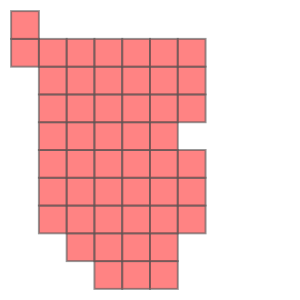

In [26]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], spacing=512,  mode='grid')
slsl.simulate_patch_sampling(MultiPoint(asMultiPoint(points[:50])), 512)

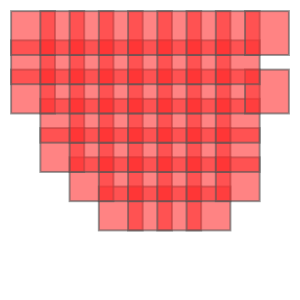

In [27]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], spacing=512*2/3,  mode='grid')
patches = slsl.simulate_patch_sampling(points, 512)
patches[:50]

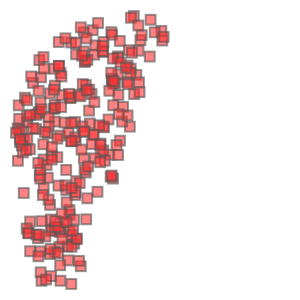

In [28]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], spacing=512,  mode='uniform_random')
slsl.simulate_patch_sampling(points, 512)

### visualization using `descartes` and `matplotlib` packages

[]

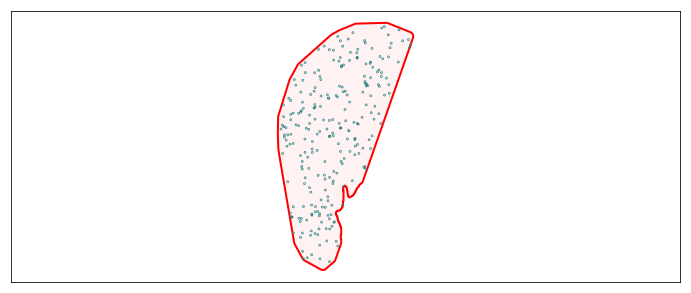

In [29]:
from shapely.geometry import MultiPoint, Point
import matplotlib.pyplot as plt
from descartes import PolygonPatch

tissue_polygon = rreader.df_tissue.polygon.iloc[0]

points = MultiPoint([pp for pp in asMultiPoint(points) if isinstance(tissue_polygon & pp, Point)])

fig, ax = plt.subplots(1, figsize=(12,5))

ax.add_patch(PolygonPatch(tissue_polygon, fc=(1,0,0,0.05), ec=(1,0,0,1), lw=2))
ax.add_patch(PolygonPatch(points.buffer(20), fc=(0,1,1,1), ec=(0.2,0.5,0.5,1), lw=2))
ax.relim()
ax.autoscale_view()
ax.axis('equal')
ax.set_xticks([])
ax.set_yticks([])

## Count number of glomeruli within each sampled patch

In [30]:
df_patches = pd.Series(patches)
df_patches.name='polygon'
df_patches = df_patches.to_frame()

# intersect glomeruli with patches
df_patches['gloms'] = df_patches['polygon'].map(lambda patch: [patch.intersection(gl) for gl in glomeruli])
# remove empty intersections
df_patches['gloms'] = df_patches['gloms'].map(lambda gloms: [x for x in gloms if isinstance(x, Polygon)])
# count gloms
df_patches['num_glom'] = df_patches['gloms'].map(len)

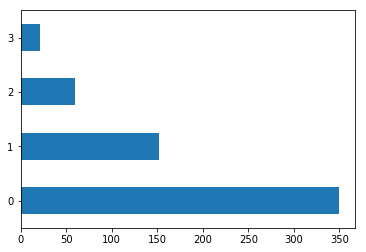

In [31]:
df_patches['num_glom'].value_counts().sort_index().plot(kind='barh')

## Load and visualize a sampled patch with 3 glomeruli

In [32]:
# select a patch with 3 gloms in it
patch = df_patches.loc[df_patches['num_glom']==3]['polygon'].iloc[0]

1936.333333333333 4009.0
(256, 256)


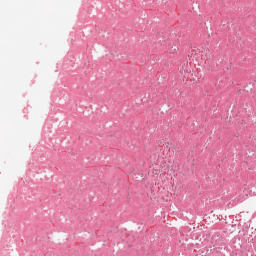

In [33]:
# load a patch given a centroid
xc, yc, _,_ = patch.centroid.bounds
print(xc, yc)
patch = rreader.get_patch(xc, yc, 1024, target_subsample=4)
print(patch.size)
patch

out_patch_size [256, 256]
extent (0, 256, 256, 0)


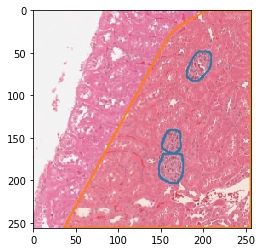

In [34]:
# load a patch & its annotation given a centroid
fig,ax, patch, patch_rois = rreader.plot_patch(xc, yc, 1024, target_subsample=4)

### for object detection algorithms, you can export the annotation in a MS-COCO dataset format
`rreader.get_patch_rois` returns a dataframe of ROIs with vertices translated to a particular patch coordinate system, together with their compressed mask representation (in columns `'counts'`)

In [35]:
patch_rois = rreader.get_patch_rois(xc, yc, 1024, scale=4, cocorle=True)
print(len(patch_rois))
dfrois = patch_rois[['id', 'name', 'area', 'vertices', 'counts', 'size']]
dfrois#.to_dict()

4


,id,name,area,vertices,counts,size
4,5,glom,714.562500,"[[192.41666666666674, 50.0], [192.166666666666...",b'VR]19e73M2N3M3N1M4M3N1N2O1N200O1O0100O1O100N...,"[256, 256]"
5,6,glom,487.218750,"[[173.16666666666674, 153.75], [173.1666666666...",b'llU17f73M4L4N2M2O2N2N100O2O000000000001N100O...,"[256, 256]"
6,7,glom,854.562500,"[[154.16666666666674, 168.75], [153.6666666666...",b'cUU1`0^74L3K5M3N101O001O001O001O000000000000...,"[256, 256]"
99,101,tissue,38087.811242,"[[36.31648889199897, 256.0], [256.0, 256.0], [...",b'n_92l72N2N2N2N2O1N2N2N2N2N2N2O1N2N2N2N2N2N2O...,"[256, 256]"


## Save slides patches for classification into category subfolders

In our case we have two categories we would like to perform image classification for:
- `backgr` -- background
- `glom`   -- glomeruli

### First, we create directories for these two categories.

Later we also will need to split our data into train and validation set. 
Therefore, we create following folder structure:

    patches/all/backgr
    patches/all/glom
    
Later we will also need:

    patches/train/backgr
    patches/train/glom
    # &
    patches/val/backgr
    patches/val/glom

In [36]:
points = slsl.sample_points(rreader.df_tissue.polygon.iloc[0], spacing=512*2/3,  mode='grid')
points = points.astype(int)
# patches = slsl.simulate_patch_sampling(points, 512)

In [39]:
outdir = 'patches'

In [40]:
!rm -rf {outdir}

In [41]:
os.makedirs(outdir, exist_ok=True)
classes = ['backgr','glom']

for subset in ['all', 'train', 'val']:
    for cc in classes:
        os.makedirs(f'{outdir}/{subset}/{cc}', exist_ok=True)

### saving patches

In [42]:
%%time
for ii, (xc, yc) in enumerate(points):
#     xc, yc = int(xc), int(yc)
    patch_img = rreader.get_patch(xc, yc, 1024, target_subsample=4)
    patch_rois = rreader.get_patch_rois(xc, yc, 1024, scale=4, cocorle=False)
    
#     condition = (patch_rois.name =='glom').any()
    # count it a 'positive' if it has more 4 or more pixels with gloms
    condition = patch_rois[(patch_rois.name =='glom')].area.sum() > 4
    category = 'glom' if condition else 'backgr'
    
    patch_img.save('{}/all/{}/x{:d}-y{:d}.png'.format(outdir, category, xc, yc))
    assert (patch_rois.area == patch_rois.polygon.map(lambda x: x.area)).all()

CPU times: user 1min 32s, sys: 8.39 s, total: 1min 40s
Wall time: 2min 13s


### collect names of the saved patches

In [43]:
filenames = []
for category in ['glom', 'backgr']:
    for ff in os.scandir('{}/all/{}/'.format(outdir, category)):
        filenames.append((ff.name, category))

### extract positions of the centroids from the file names

In [44]:
import re
pattern = re.compile(r'x(?P<x>\d+)-y(?P<y>\d+)')

df_files = []
for fn, cat in filenames:
    res = pattern.match(fn)
    
    if res is not None:
        res_dict = res.groupdict()
        res_dict['category'] = cat
        res_dict['fn'] = fn
        df_files.append(res_dict)
        
df_files = pd.DataFrame(df_files)
df_files.x = df_files.x.astype(int)
df_files.y = df_files.y.astype(int)

In [45]:
df_files.head()

,category,fn,x,y
0,glom,x1595-y8105.png,1595,8105
1,glom,x2960-y12883.png,2960,12883
2,glom,x8080-y16638.png,8080,16638
3,glom,x1936-y14590.png,1936,14590
4,glom,x6373-y17321.png,6373,17321


## Create training and validation set 
by assiging 80% of patches in the top of the slide into training set and the rest into the test set

In [46]:
y_80 = np.percentile(df_files.y, 80)

In [47]:
df_files['subset'] = (df_files.y>y_80).map(lambda x: 'val' if x else 'train').astype('category')
df_files['subset'].value_counts()

train    476
val      107
Name: subset, dtype: int64

### visualize location of training and validation data within the slide

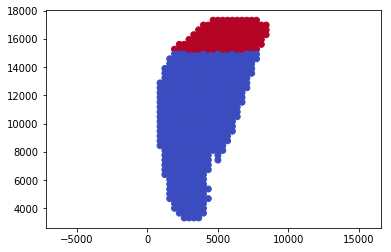

In [48]:
plt.scatter(df_files.x, df_files.y, c=df_files.subset.cat.codes, cmap='coolwarm')
plt.axis('equal');

### create symlinks for the training and validation images

In [53]:
# !rm patches/train/*/*png
# !rm patches/val/*/*png

In [49]:
def get_input_path(x, outdir=outdir):
    return '../../{}/{}/{}'.format('all', x['category'],x['fn'])

def get_output_path(x,outdir=outdir):
    return '{}/{}/{}/{}'.format(outdir, x['subset'], x['category'],x['fn'])
    
df_files.apply(lambda x: os.symlink(get_input_path(x), get_output_path(x)), axis=1)
pass

In [50]:
!ls {outdir}/val/glom | head

x1936-y15273.png
x2277-y15273.png
x2619-y15273.png
x2619-y15614.png
x2960-y15273.png
x2960-y15614.png
x2960-y15955.png
x3301-y15273.png
x3301-y15614.png
x3301-y15955.png
